### Random forest

Here we train three random forests, one for each of the fire types. We feed them through an sklearn pipeline, save them and plot graphs of feature importance and ROC curves. There is also some investiagation of recall and precision. 

Maps are generated for 2017,2018 and 2019

In [1]:
#Modelling tools contains custom functions
import Modelling_tools as MT
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#This will be useful for assessing the model performance
from sklearn import metrics

In [3]:
#For saving the final models
import pickle

In [4]:
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

### Load the assembled dataset (see codes for dataset assembly)

In [5]:
dataset = pd.read_csv("/Users/rmartinshort/Documents/Insight/Project/census_block_prediction/Fully_merged_dataset_Autogenerated_plus.csv")

In [6]:
#Do something about the NaNs (~10% of dataset)
#Where we don't have information about the property, fill
#unknownusetype and set proportions of use types to zero
#Then set the remaining Na values to be the mean 

#In practice the model output does not change much no matter
#what we value we choose to fill them with. Its also possible to train
#a model without NaNs, but then we end up with missing blocks
#in the web app 

dataset['UnkownUseType'].fillna(1,inplace=True)
dataset['S'].fillna(1,inplace=True)
values = {'COMH':0, 'COMM':0, 'COMO':0, 'COMR':0, 'GOVT':0, 'IND':0, 'MISC':0,
       'MRES':0, 'SRES':0, 'A':0, 'B':0, 'C':0, 'D':0}
dataset = dataset.fillna(value=values)
dataset.fillna(dataset.mean(),inplace=True)

In [7]:
dataset.drop(['IDyear_x.1'],inplace=True,axis=1)

In [8]:
#Parameters for grid search. These were refined from a much larger set
test_parameters_RF = {
        'classify__n_estimators': (100,200),
        'classify__max_depth': (8,15),
        'classify__min_samples_split':(8,15),
        'classify__min_samples_leaf':(20,50,80),
        'classify__class_weight':('balanced','balanced_subsample')
}

### External fires, 2018

In [9]:
X,y,Xholdout,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2018)

In [10]:
#Load the map geometry data. We need to make sure that the cell IDs are in correct order
GISCELLS = list(holdout['GISYEARJOIN'])
SF_blocks_years = gpd.read_file('SF_block_years_2010.shp')
mapdata = SF_blocks_years[SF_blocks_years['GISYEARJOI'].isin(GISCELLS)]

In [11]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [12]:
#Run grid search for the best model
Xcols_EF, RC_model_EF_2018 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (20, 50, 80), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 16.6min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 22.8min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1387.044s

Best score: 0.843
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 15
	classify__min_samples_leaf: 50
	classify__min_samples_split: 8
	classify__n_estimators: 200


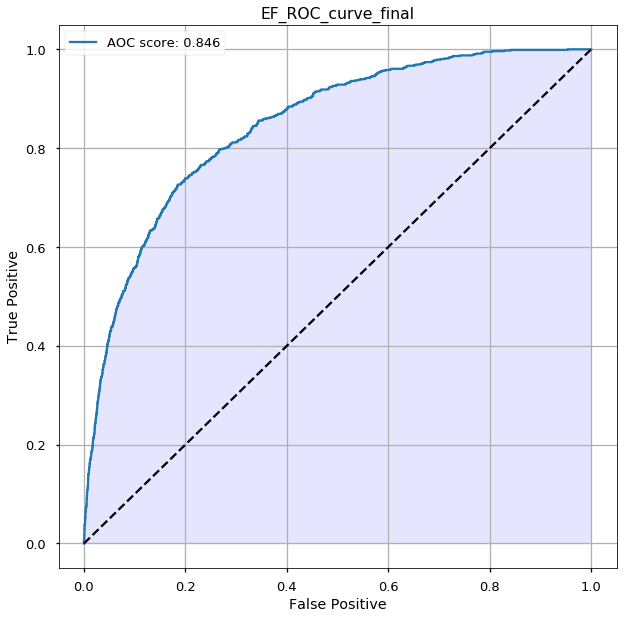

In [13]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_EF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_EF_2018,
                                                                                title='EF_ROC_curve_final')

In [14]:
fprobs = RC_model_EF_2018.predict_proba(Xholdout)

In [15]:
fclass = RC_model_EF_2018.predict(Xholdout)

This is reasonable: With a theshold of 0.5 we catch the majority of the external fires, but we end up flagging too many cells, so the precision is low. We need to raise the threshold if we want to designate a useful proportion of the city

In [16]:
metrics.recall_score(yholdoutEF,fclass)

0.7733990147783252

In [17]:
metrics.precision_score(yholdoutEF,fclass)

0.28454916175804257

In [18]:
metrics.f1_score(yholdoutEF,fclass)

0.4160317986088108

These numbers are interesting and useful from a storytelling perspective: The model has high recall (flags the majority of blocks that will contain fires) but low precision (many of the blocks it flags don't have fires) at a threshold of 0.5. To combat this, we need to have some reasonable way of raising the threshold - and we can do this using the mean cell method

In [20]:
feature_importances = RC_model_EF_2018.named_steps['classify'].feature_importances_

In [21]:
inds = feature_importances.argsort()[::-1]

In [22]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_EF[index])

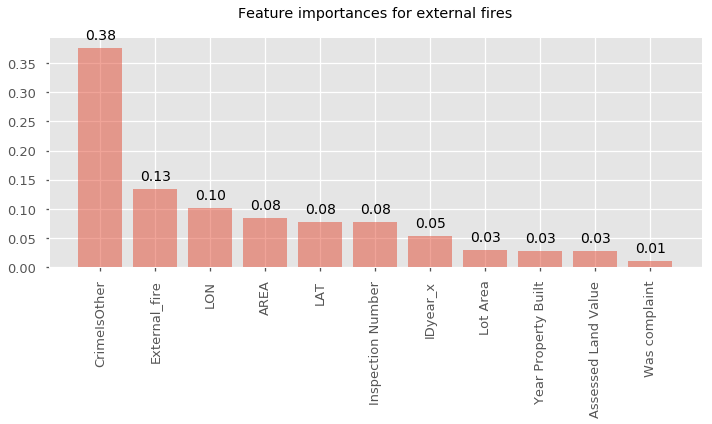

In [23]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for external fires",pad=20)
plt.tight_layout()
plt.savefig("External_fires_fimportance_final.png",dpi=400)

### Save the model!

In [24]:
filename = 'RC_model_EF_2018.sav'
pickle.dump(RC_model_EF_2018, open(filename, 'wb'))

### Function to generate map

In [25]:
def generate_foilum_map(riskmapdf,fires_df=None,firetype='structure',year='2018'):
    
    if firetype == 'external':
        HRzone = 'EFHR'
        Fprob = 'fprob_EF'
        Fid = 'EF'
        layer_name = 'External fires'
        output_name = 'external_'+year+'.html'
        
    elif firetype == 'vehicle':
        HRzone = 'VFHR'
        Fprob = 'fprob_VF'
        Fid = 'VF'
        layer_name = 'Vehicle fires'
        output_name = 'vehicle_'+year+'.html'
        
    elif firetype == 'structure':
        HRzone = 'SFHR'
        Fprob = 'fprob_SF'
        Fid = 'SF'
        layer_name = 'Structure fires'
        output_name = 'structure_'+year+'.html'
    
    
    riskmapdf['BLOCKID'] = np.arange(len(riskmapdf))
    gdf_wgs84 = riskmapdf.copy()
    gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


    m = folium.Map(location=[37.76, -122.42],zoom_start=13,
                   tiles="CartoDB positron",
                  width='100%',
                  height='100%')


    #Fill in the high risk zone layer
    folium.Choropleth(
        name = 'High risk zone',
        geo_data=gdf_wgs84[gdf_wgs84[HRzone]==1].to_json(),
        key_on = 'feature.properties.{}'.format('BLOCKID'),
        max_zoom=16,
        fill_opacity=0.5,
        fill_color='#ff0000',
        line_opacity=0.1,
        highlight=True,
        legend_name='High risk zone').add_to(m)

    #Fill in the risk score layer
    folium.Choropleth(
        show=False,
        name='Fire risk score',
        geo_data=gdf_wgs84.to_json(),data=riskmapdf,columns=['BLOCKID',Fprob],
        key_on = 'feature.properties.{}'.format('BLOCKID'),
        max_zoom=16,
        fill_opacity=0.8,
        fill_color='YlOrRd',
        line_opacity=0.1,
        highlight=True,
        legend_name='Fire risk score').add_to(m)
    
    if year != '2019':

        #Add the locations of actual fires
        coords = []
        popups = []
        icons = []
        for index, row in fires_df.iterrows():
            if row[Fid] == 1:
                lat = row['Lat']
                lon = row['Lon']
                popup = 'Fire at Lat: %.4f, Lon: %.4f' %(lat,lon)
                coords.append([lat,lon])
                popups.append(popup)
                icons.append(folium.Icon(color='white', 
                                      icon_color='red', 
                                      icon='fire', 
                                      angle=0,
                                      prefix='fa'))

        plt_lyr = folium.FeatureGroup(name = layer_name)

        plt_lyr.add_children(MarkerCluster(locations = coords, popups = popups,icons = icons, overlay=True))
        m.add_children(plt_lyr)

    m.add_child(folium.LatLngPopup())

    folium.LayerControl().add_to(m)

    m.save(output_name)

### Generate map for 2018 external fires

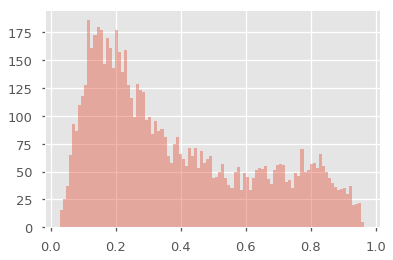

In [26]:
EF_2018_pred = RC_model_EF_2018.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100)

In [27]:
fscoreEF = 10.0*EF_2018_pred[:,1] #put fscore on scale from zero to 10, but 
#don't normalize since this will result in information loss

In [28]:
#Find the thresholds for high risk zones
ncells_EF = 500 #number of blocks we choose to flag  
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
print(vallimEF)

8.300156503132271


In [29]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

In [30]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                                 'EFHR':fscoreEFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [31]:
fires_2018 = pd.read_csv("2018_fires.csv")

In [32]:
generate_foilum_map(riskmap_2018,fires_2018,firetype='external',year='2018')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Generate 2019 prediction for external fires

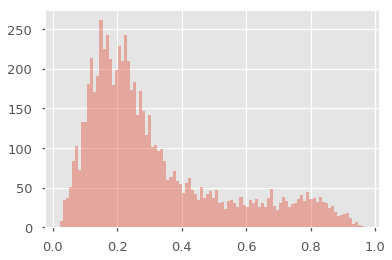

In [33]:
EF_2019_pred = RC_model_EF_2018.predict_proba(Xuseforfuture)
sns.distplot(EF_2019_pred[:,1],kde=False,bins=100)

In [34]:
fscoreEF = 10.0*EF_2019_pred[:,1] #put fscore on scale from zero to 10

In [35]:
#Find the thresholds for high risk zones
ncells_EF = 560 #number of blocks we choose to flag  
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
print(vallimEF)

7.439118557207458


In [36]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

In [37]:
riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                                 'EFHR':fscoreEFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [38]:
generate_foilum_map(riskmap_2019,firetype='external',year='2019')

### External fires, 2017

In [39]:
X,y,Xholdout,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2017)

In [40]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [41]:
#Run grid search for the best model
Xcols_EF, RC_model_EF_2017 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (20, 50, 80), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 14.9min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 19.4min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1171.660s

Best score: 0.843
Best parameters set:
	classify__class_weight: 'balanced'
	classify__max_depth: 15
	classify__min_samples_leaf: 50
	classify__min_samples_split: 8
	classify__n_estimators: 100


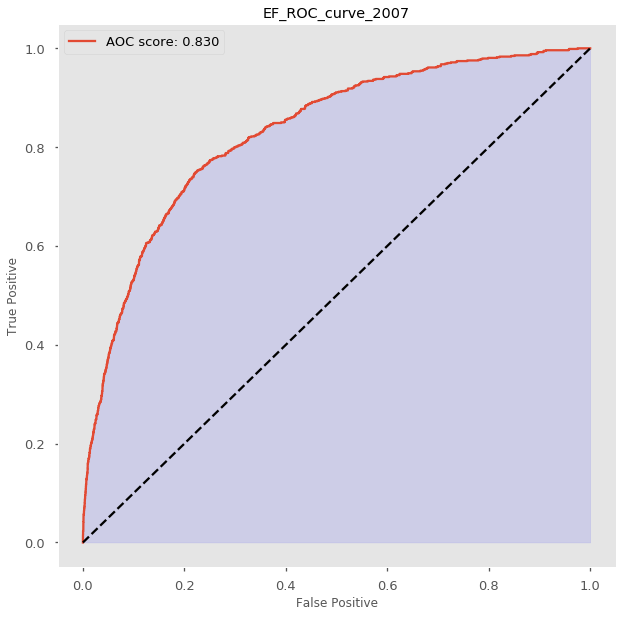

In [42]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_EF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_EF_2017,
                                                                                title='EF_ROC_curve_2007')

In [43]:
fclass = RC_model_EF_2017.predict(Xholdout)
fprobs = RC_model_EF_2017.predict_proba(Xholdout)

In [44]:
metrics.recall_score(yholdoutEF,fclass)

0.7739018087855297

In [45]:
metrics.precision_score(yholdoutEF,fclass)

0.2658677319130049

In [46]:
metrics.f1_score(yholdoutEF,fclass)

0.39577139081598944

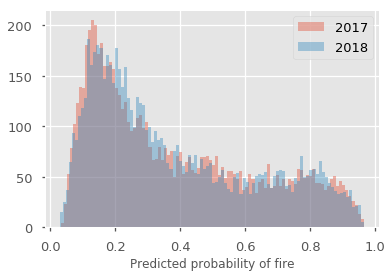

In [47]:
EF_2017_pred = RC_model_EF_2017.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(EF_2017_pred[:,1],kde=False,bins=100,label='2017')
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100,label='2018')
plt.legend(loc='best')
plt.xlabel('Predicted probability of fire')
plt.savefig('Prob_dist_2017_vs_2018.png',dpi=300)

In [48]:
fscoreEF = 10.0*EF_2017_pred[:,1] #put fscore on scale from zero to 10

In [49]:
#Find the thresholds for high risk zones
ncells_EF = 560 #number of blocks we choose to flag  
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
print(vallimEF)

8.17935278751519


In [50]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

In [51]:
riskmap_2017 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                                 'EFHR':fscoreEFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [52]:
fires_2017 = pd.read_csv("2017_fires.csv")

In [53]:
generate_foilum_map(riskmap_2017,fires_df=fires_2017,firetype='external',year='2017')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [54]:
filename = 'RC_model_EF_2017.sav'
pickle.dump(RC_model_EF_2017, open(filename, 'wb'))

### Vehicle fires, 2018

In [55]:
X,y,Xholdout,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2018)

In [56]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [57]:
#Run grid search for the best model
Xcols_VF, RC_model_VF_2018 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (20, 50, 80), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.9min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 20.9min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1263.112s

Best score: 0.769
Best parameters set:
	classify__class_weight: 'balanced'
	classify__max_depth: 15
	classify__min_samples_leaf: 80
	classify__min_samples_split: 8
	classify__n_estimators: 100


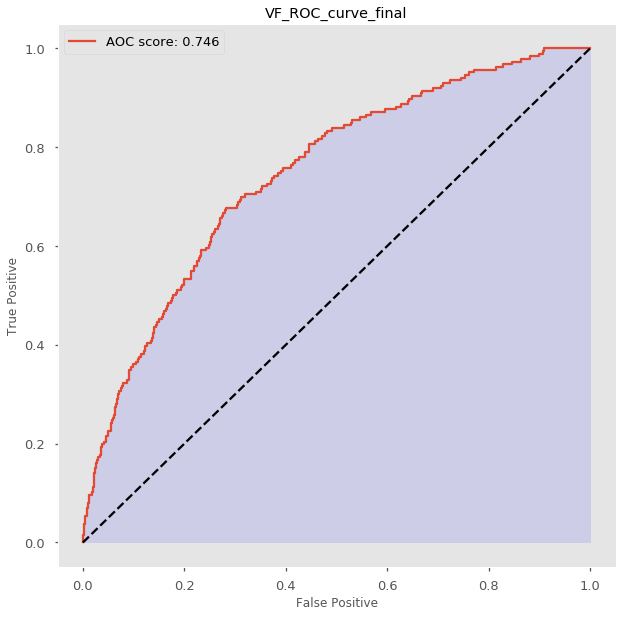

In [58]:
ROCplot, false_positive_VF, true_positive_VF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutVF,RC_model_VF_2018,
                                                                               title='VF_ROC_curve_final')

In [59]:
fprobsvh = RC_model_VF_2018.predict_proba(Xholdout)
fclassvh = RC_model_VF_2018.predict(Xholdout)

These are the recall and precision scores for a threshold of 0.5. They're not great! But this is to be expected

In [60]:
metrics.recall_score(yholdoutVF,fclassvh)

0.5

In [61]:
metrics.precision_score(yholdoutVF,fclassvh)

0.06823184152604549

In [62]:
feature_importances = RC_model_VF_2018.named_steps['classify'].feature_importances_

In [63]:
inds = feature_importances.argsort()[::-1]

In [64]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_VF[index])

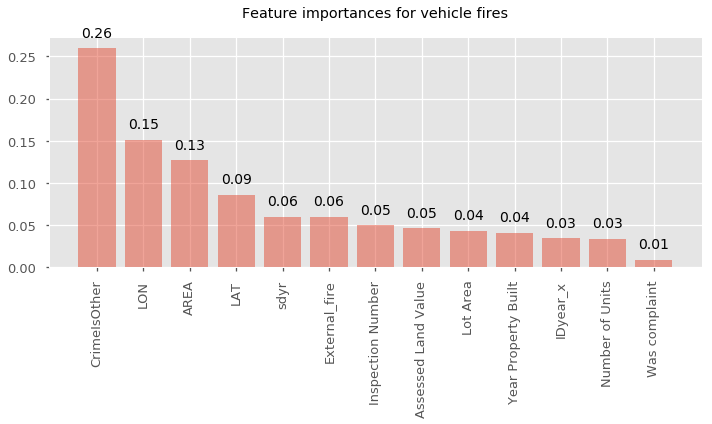

In [65]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for vehicle fires",pad=20)
plt.tight_layout()
plt.savefig("Vehicle_fires_fimportance_final.png",dpi=400)

### Save the model!

In [67]:
filename = 'RC_model_VF_2018.sav'
pickle.dump(RC_model_VF_2018, open(filename, 'wb'))

### Generate map for 2018 vehicle fires

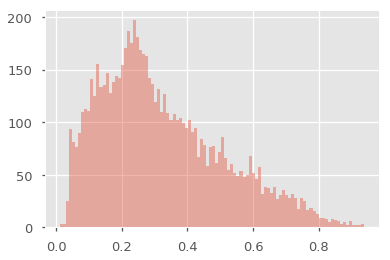

In [68]:
VF_2018_pred = RC_model_VF_2018.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(VF_2018_pred[:,1],kde=False,bins=100)

In [69]:
fscoreVF = 10.0*VF_2018_pred[:,1] #put fscore on scale from zero to 10

In [70]:
#Find the thresholds for high risk zones
ncells_VF = 180 #number of blocks we choose to flag  
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimVF)

7.466631528349785


In [71]:
fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

In [72]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_VF':fscoreVF,
                                 'VFHR':fscoreVFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [73]:
generate_foilum_map(riskmap_2018,fires_df=fires_2018,firetype='vehicle',year='2018')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Generate 2019 prediction for vehicle fires

6.720335645514806


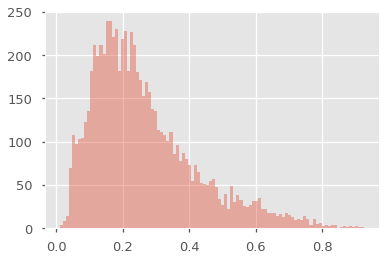

In [74]:
#Xuseforfuture must come from the 2018 holdout!!
VF_2019_pred = RC_model_VF_2018.predict_proba(Xuseforfuture)
sns.distplot(VF_2019_pred[:,1],kde=False,bins=100)
fscoreVF = 10.0*VF_2019_pred[:,1] #put fscore on scale from zero to 10

#Find the thresholds for high risk zones
ncells_VF = 180 #number of blocks we choose to flag  
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimVF)

fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_VF':fscoreVF,
                                 'VFHR':fscoreVFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2019,firetype='vehicle',year='2019')

### Vehicle fires, 2017

In [75]:
X,y,Xholdout,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2017)

In [76]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [77]:
#Run grid search for the best model
Xcols_VF, RC_model_VF_2017 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (20, 50, 80), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 14.0min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 18.4min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1118.215s

Best score: 0.770
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 8
	classify__min_samples_leaf: 50
	classify__min_samples_split: 8
	classify__n_estimators: 200


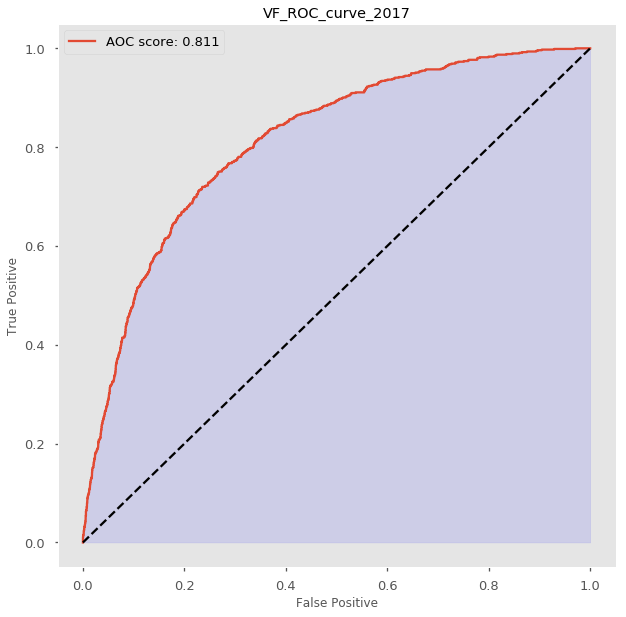

In [91]:
ROCplot, false_positive_VF, true_positive_VF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_VF_2017,
                                                                                title='VF_ROC_curve_2017')

In [79]:
fclass = RC_model_VF_2017.predict(Xholdout)
fprobs = RC_model_VF_2017.predict_proba(Xholdout)

In [80]:
metrics.recall_score(yholdoutVF,fclass)

0.6

In [81]:
metrics.precision_score(yholdoutVF,fclass)

0.07837181044957472

In [82]:
metrics.f1_score(yholdoutVF,fclass)

0.138635142396561

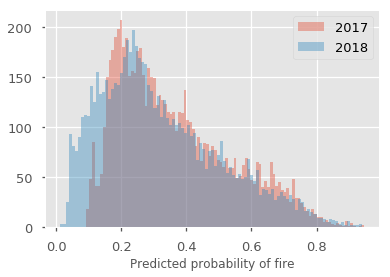

In [92]:
VF_2017_pred = RC_model_VF_2017.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(VF_2017_pred[:,1],kde=False,bins=100,label='2017')
sns.distplot(VF_2018_pred[:,1],kde=False,bins=100,label='2018')
plt.legend(loc='best')
plt.xlabel('Predicted probability of fire')
plt.savefig('Prob_dist_2017_vs_2018_VF.png',dpi=300)

In [93]:
fscoreVF = 10.0*VF_2017_pred[:,1] #put fscore on scale from zero to 10

In [94]:
#Find the thresholds for high risk zones
ncells_VF = 180 #number of blocks we choose to flag  
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimVF)

7.4568075959083755


In [95]:
fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

In [96]:
riskmap_2017 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_VF':fscoreVF,
                                 'VFHR':fscoreVFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [97]:
fires_2017 = pd.read_csv("2017_fires.csv")

In [98]:
generate_foilum_map(riskmap_2017,fires_df=fires_2017,firetype='vehicle',year='2017')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [99]:
filename = 'RC_model_VF_2017.sav'
pickle.dump(RC_model_VF_2017, open(filename, 'wb'))

### Structure fires, 2018

In [100]:
X,y,Xholdout,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2018)

In [101]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [102]:
#Run grid search for the best model
Xcols_SF, RC_model_SF = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (20, 50, 80), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 21.9min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 29.9min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1801.903s

Best score: 0.810
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 8
	classify__min_samples_leaf: 80
	classify__min_samples_split: 15
	classify__n_estimators: 100


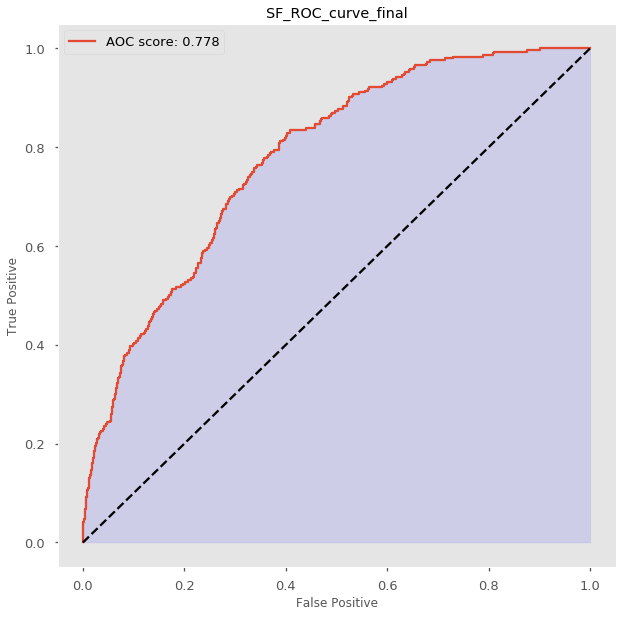

In [103]:
ROCplot, false_positive_SF, true_positive_SF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutSF,RC_model_SF,
                                                                               title='SF_ROC_curve_final')

In [104]:
fprobssf = RC_model_SF.predict_proba(Xholdout)
fclasssf = RC_model_SF.predict(Xholdout)

These are the recall and precision scores for a threshold of 0.5. They're not great! But this is to be expected

In [105]:
metrics.recall_score(yholdoutSF,fclasssf)

0.6061643835616438

In [106]:
metrics.precision_score(yholdoutSF,fclasssf)

0.09058341862845445

In [107]:
feature_importances = RC_model_SF.named_steps['classify'].feature_importances_

In [108]:
inds = feature_importances.argsort()[::-1]

In [109]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_SF[index])

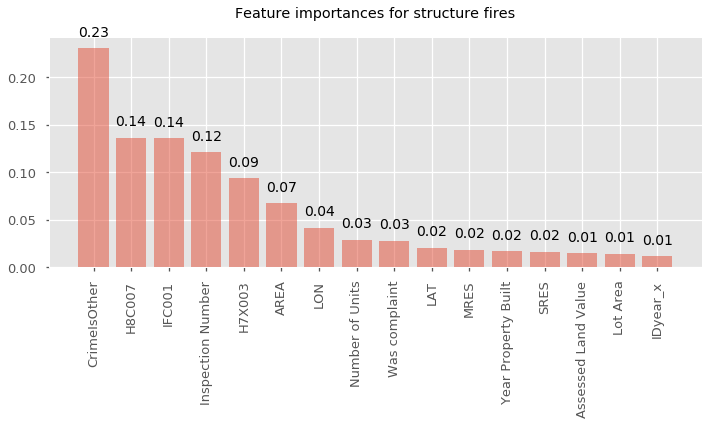

In [110]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels[:-2],ylabels[:-2],alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for structure fires",pad=20)
plt.tight_layout()
plt.savefig("Structure_fires_fimportance_final.png",dpi=400)

### Save the model

In [111]:
filename = 'RC_model_SF_2018.sav'
pickle.dump(RC_model_SF, open(filename, 'wb'))

### Generate 2019 prediction for strucure fires

6.740792833597514


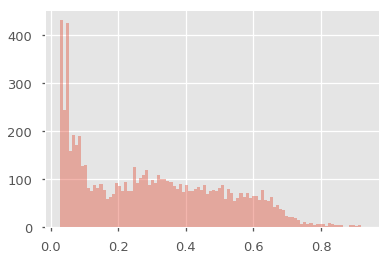

In [112]:
#Xuseforfuture must come from the 2018 holdout!!
SF_2019_pred = RC_model_SF.predict_proba(Xuseforfuture)
sns.distplot(SF_2019_pred[:,1],kde=False,bins=100)
fscoreSF = 10.0*SF_2019_pred[:,1] #put fscore on scale from zero to 10

#Find the thresholds for high risk zones
ncells_SF = 290  #number of blocks we choose to flag  
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
print(vallimSF)

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_SF':fscoreSF,
                                 'SFHR':fscoreSFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2019,firetype='structure',year='2019')

### Generate 2018 map for structure fires

In [113]:
SF_2018_pred = RC_model_SF.predict_proba(Xholdout)

fscoreSF = 10.0*SF_2018_pred[:,1] #put fscore on scale from zero to 10

#Find the thresholds for high risk zones
ncells_SF = 290 #number of blocks we choose to flag  
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
print(vallimSF)

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_SF':fscoreSF,
                                 'SFHR':fscoreSFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2018,fires_df=fires_2018,firetype='structure',year='2018')

7.297231762432384


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Structure fires, 2017

In [114]:
X,y,Xholdout,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2017)

pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

#Run grid search for the best model
Xcols_VF, RC_model_SF_2017 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (20, 50, 80), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 24.9min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1509.115s

Best score: 0.814
Best parameters set:
	classify__class_weight: 'balanced'
	classify__max_depth: 15
	classify__min_samples_leaf: 80
	classify__min_samples_split: 8
	classify__n_estimators: 200


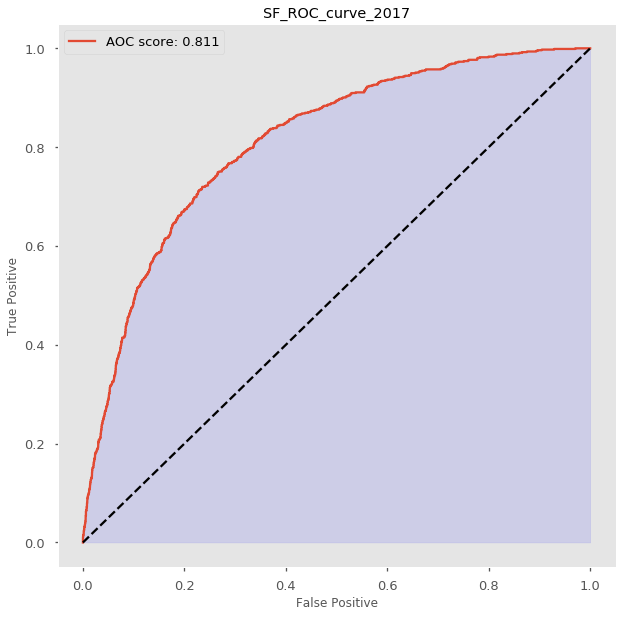

In [119]:
ROCplot, false_positive_SF, true_positive_SF, thresholds_SF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_VF_2017,
                                                                                title='SF_ROC_curve_2017')

In [120]:
SF_2017_pred = RC_model_SF_2017.predict_proba(Xholdout)
fscoreSF = 10.0*SF_2017_pred[:,1] #put fscore on scale from zero to 10

In [121]:
#Find the thresholds for high risk zones
ncells_SF = 290  #number of blocks we choose to flag  
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
print(vallimSF)

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

riskmap_2017 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_SF':fscoreSF,
                                 'SFHR':fscoreSFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2017,fires_df=fires_2017,firetype='structure',year='2017')

7.351661019919811


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [122]:
filename = 'RC_model_SF_2017.sav'
pickle.dump(RC_model_SF, open(filename, 'wb'))

In [123]:
holdout.to_csv("2017_predictfires.csv",index=False)